<a href="https://colab.research.google.com/github/hwangho-kim/pure-LAD/blob/master/LAD_%EB%B6%84%EB%A5%98%EA%B8%B0_(%EB%A6%AC%ED%8C%A9%ED%86%A0%EB%A7%81_%EB%B2%84%EC%A0%84).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Training EagerPatterns LAD Classifier (Refactored) ---

--- EagerPatterns Classification Report ---
              precision    recall  f1-score   support

           0       0.88      0.98      0.92        43
           1       0.98      0.92      0.95        71

    accuracy                           0.94       114
   macro avg       0.93      0.95      0.94       114
weighted avg       0.94      0.94      0.94       114


--- EagerPatterns Rule List ---
EagerPatterns Rule List:
[Class 0]
  IF mean radius > 13.2900 AND worst texture > 20.2250 AND worst perimeter > 91.6950 AND worst perimeter > 105.9500 AND worst perimeter > 120.3500 THEN class=0 (conf=1.00, supp=0.25, lift=2.69)
  IF mean radius > 13.2900 AND mean texture > 16.6900 AND worst perimeter > 91.6950 AND worst perimeter > 105.9500 AND worst perimeter > 120.3500 THEN class=0 (conf=1.00, supp=0.25, lift=2.69)
  IF mean texture > 16.6900 AND mean texture > 19.4850 AND perimeter error > 1.9150 AND area error > 32.1650 AND w

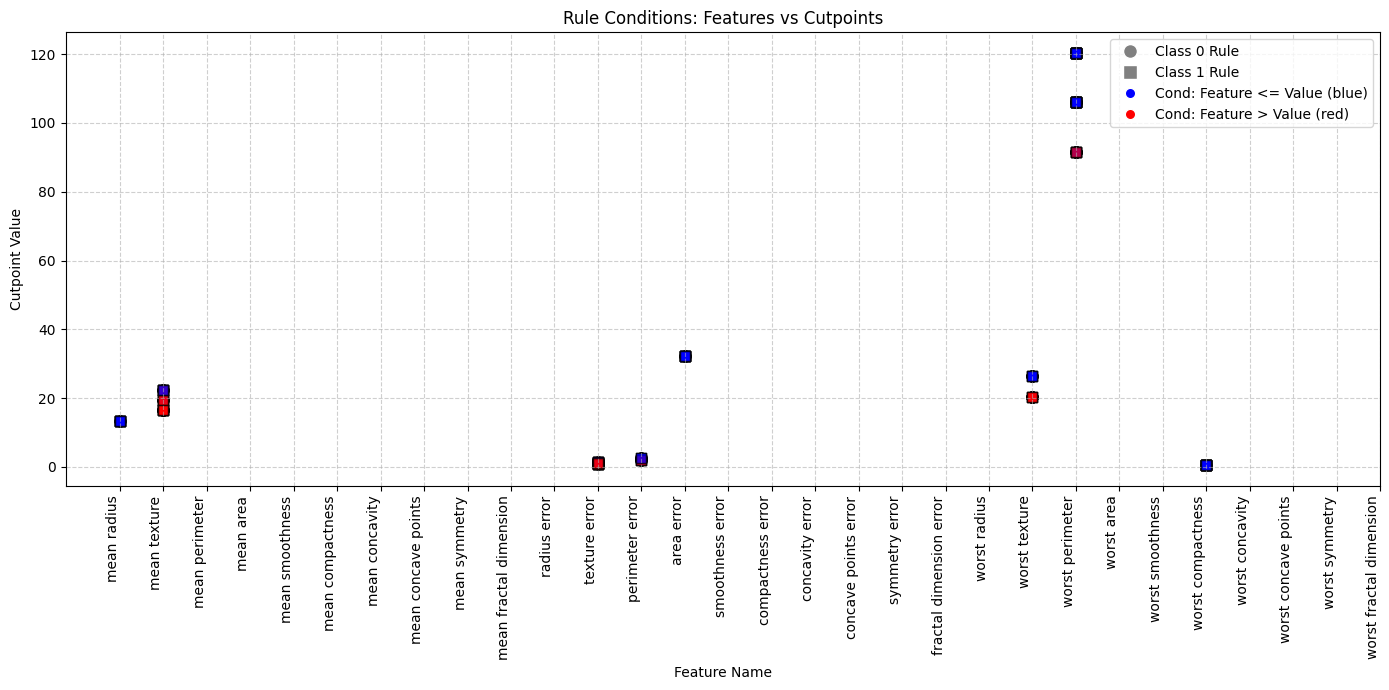

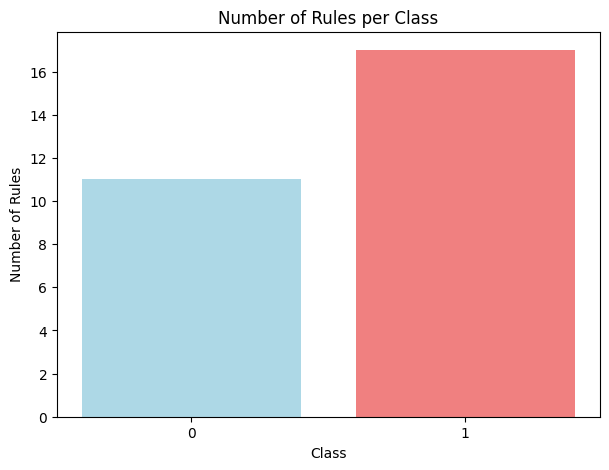

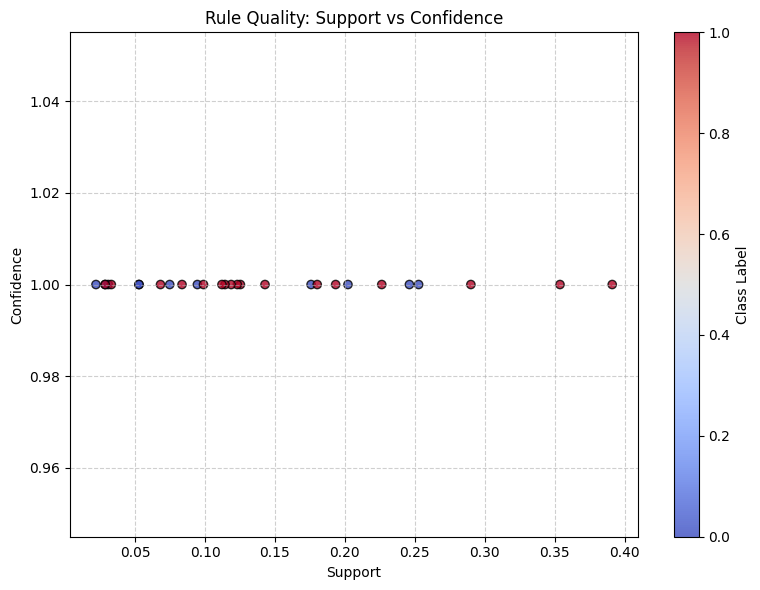

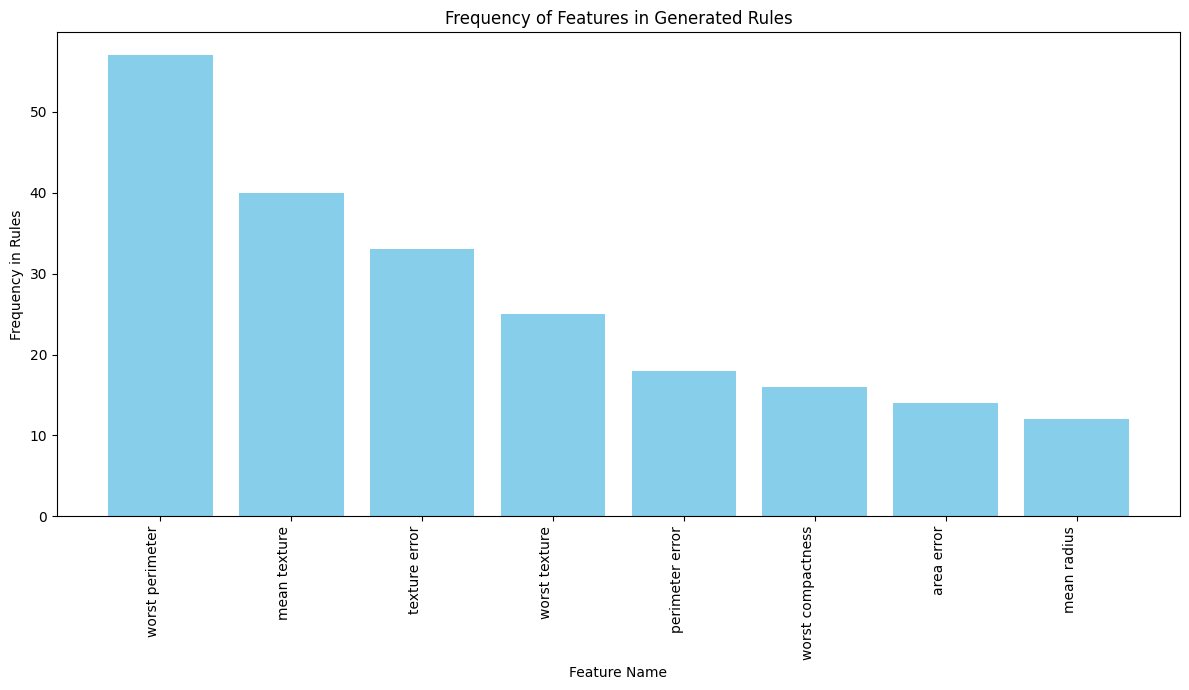

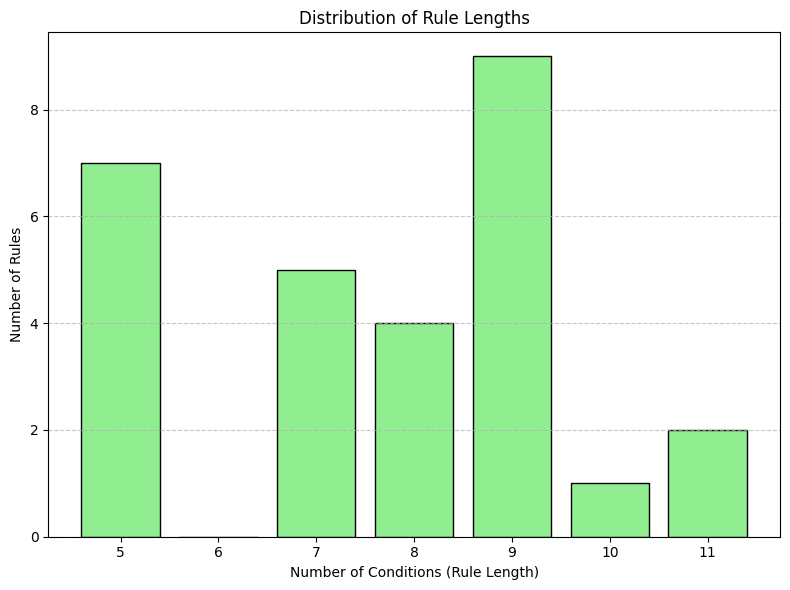

In [1]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import json
from typing import List, Dict, Tuple, Any

class CutpointBinarizer():
    """
    연속형 데이터를 최적의 절단점을 찾아 이진 데이터로 변환합니다.
    Converts continuous data to binary data by finding optimal cutpoints.
    """
    def __init__(self, tolerance: float = 0.0):
        self.tolerance = tolerance
        self.__cutpoints: Dict[int, Tuple[int, float]] = {}
        self.__cutpoint_order: List[int] = []

    def get_cutpoints(self) -> Dict[int, Tuple[int, float]]:
        return self.__cutpoints

    def get_cutpoint_order(self) -> List[int]:
        return self.__cutpoint_order

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'CutpointBinarizer':
        """
        데이터에 대한 최적의 절단점을 찾습니다.
        """
        self.__cutpoints.clear()
        self.__cutpoint_order = []

        for att_idx, col_data in enumerate(X.T):
            labels_prev = None
            u_prev = None

            sorted_unique_vals = sorted(np.unique(col_data))

            if not sorted_unique_vals:
                continue

            for v_curr in sorted_unique_vals:
                if u_prev is None:
                    u_prev = v_curr
                    labels_prev = set(y[np.where(col_data == v_curr)[0]])
                    continue

                variation = v_curr - u_prev
                labels_curr = set(y[np.where(col_data == v_curr)[0]])

                # --- REFACTORED ---
                # 절단점 생성 로직을 간소화했습니다.
                # 이전 값의 클래스 집합과 현재 값의 클래스 집합이 다를 때만 절단점을 생성합니다.
                # 이는 더 명확하고 불필요한 절단점 생성을 방지합니다.
                if variation > self.tolerance and labels_prev != labels_curr:
                    cid = len(self.__cutpoints)
                    self.__cutpoints[cid] = (att_idx, u_prev + variation / 2.0)
                    self.__cutpoint_order.append(cid)

                labels_prev = labels_curr
                u_prev = v_curr
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        학습된 절단점을 사용하여 데이터를 이진화합니다.
        """
        if not self.__cutpoints:
             return np.empty((X.shape[0], 0), dtype=bool)

        binarized_cols = []
        for cid in self.__cutpoint_order:
            att, cutpoint_val = self.__cutpoints[cid]
            if att < X.shape[1]:
                col_to_binarize = X[:, att]
                binarized_cols.append(col_to_binarize <= cutpoint_val)

        if not binarized_cols:
            return np.empty((X.shape[0], 0), dtype=bool)

        return np.vstack(binarized_cols).T

    def fit_transform(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.fit(X, y).transform(X)

class UnWeightedSetCoveringProblem():
    """
    Set Covering Problem (SCP) 인스턴스 빌더.
    행은 서로 다른 클래스의 샘플 쌍이고, 열은 이진 특성인 행렬을 생성합니다.
    특성이 해당 쌍을 구분하면 항목은 1이 됩니다.
    """
    def __init__(self):
        self.__scp: np.ndarray = np.array([])

    # --- REFACTORED ---
    # 성능 최적화를 위해 fit 메서드를 재작성했습니다.
    # 중첩된 파이썬 루프 대신 NumPy 브로드캐스팅을 사용하여 모든 샘플 쌍에 대한
    # 구별 특성을 한 번에 계산합니다. 이는 데이터가 클 때 상당한 속도 향상을 가져옵니다.
    def fit(self, Xbin: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        주어진 이진 데이터와 레이블로부터 Set Covering Problem 행렬을 생성합니다.
        """
        self.__scp = []
        labels = np.unique(y)

        if len(labels) < 2:
            self.__scp = np.empty((0, Xbin.shape[1]), dtype=bool)
            return self.__scp

        # 모든 클래스 조합에 대해 반복
        for i in range(len(labels)):
            for j in range(i + 1, len(labels)):
                samples_i = Xbin[y == labels[i]]
                samples_j = Xbin[y == labels[j]]

                if samples_i.shape[0] == 0 or samples_j.shape[0] == 0:
                    continue

                # NumPy 브로드캐스팅을 사용하여 모든 쌍의 XOR 연산을 한 번에 수행
                # samples_i: (n_i, n_features) -> (n_i, 1, n_features)
                # samples_j: (n_j, n_features)
                # 결과: (n_i, n_j, n_features)
                distinguishing_features = np.bitwise_xor(samples_i[:, np.newaxis, :], samples_j)

                # 2D 배열 (쌍의 수, 특성 수)로 변환
                num_pairs = distinguishing_features.shape[0] * distinguishing_features.shape[1]
                if num_pairs > 0:
                    self.__scp.append(distinguishing_features.reshape(num_pairs, Xbin.shape[1]))


        if not self.__scp:
            self.__scp = np.empty((0, Xbin.shape[1]), dtype=bool)
        else:
            self.__scp = np.vstack(self.__scp)

        return self.__scp

class EfficientGreedySetCover():
    """
    효율적인 Greedy Set Cover 해결기.
    모든 요소(행)를 커버하는 특성(SCP 행렬의 열)의 부분 집합을 선택합니다.
    """
    def __init__(self):
        self.__selected_sets_indices: List[int] = []
        self.scp_builder = UnWeightedSetCoveringProblem()

    def get_selected(self) -> np.ndarray:
        return np.array(sorted(self.__selected_sets_indices), dtype=int)

    def fit(self, Xbin: np.ndarray, y: np.ndarray) -> 'EfficientGreedySetCover':
        self.__selected_sets_indices = []
        scp_matrix = self.scp_builder.fit(Xbin, y)

        if scp_matrix.size == 0:
            return self

        num_elements_to_cover, num_potential_sets = scp_matrix.shape
        if num_elements_to_cover == 0 or num_potential_sets == 0:
            return self

        elements_covered_mask = np.zeros(num_elements_to_cover, dtype=bool)
        available_sets_mask = np.ones(num_potential_sets, dtype=bool)

        while np.any(~elements_covered_mask):
            current_available_set_indices = np.where(available_sets_mask)[0]
            if not current_available_set_indices.size:
                break

            sub_scp = scp_matrix[~elements_covered_mask, :][:, current_available_set_indices]
            if sub_scp.shape[0] == 0: break

            coverage_counts = sub_scp.sum(axis=0)
            if not coverage_counts.size or np.all(coverage_counts == 0):
                break

            best_set_local_idx = np.argmax(coverage_counts)
            if coverage_counts[best_set_local_idx] == 0: break

            best_set_global_idx = current_available_set_indices[best_set_local_idx]
            self.__selected_sets_indices.append(int(best_set_global_idx))

            elements_covered_mask |= scp_matrix[:, best_set_global_idx]
            available_sets_mask[best_set_global_idx] = False

        return self

    def transform(self, Xbin: np.ndarray) -> np.ndarray:
        if not self.__selected_sets_indices:
            return np.empty((Xbin.shape[0], 0), dtype=Xbin.dtype)

        return Xbin[:, sorted(self.__selected_sets_indices)]

    def fit_transform(self, Xbin: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.fit(Xbin, y).transform(Xbin)

class EagerPatterns:
    """
    Eager 학습 패턴 기반 분류기. 규칙은 fit 단계에서 생성됩니다.
    """
    def __init__(self, binarizer: CutpointBinarizer, selector: EfficientGreedySetCover, min_conf: float=0.7, min_supp: float=0.01):
        self.__rules: List[Dict[str, Any]] = []
        self.__binarizer = binarizer
        self.__selector = selector
        self.__min_conf = min_conf
        self.__min_supp = min_supp

        self.labels_: np.ndarray = np.array([])
        self.__cutpoints_map: Dict[int, Tuple[int, float]] = {}
        self.__selected_cutpoint_info: List[Tuple[int, float]] = []
        self.__feature_names: List[str] = []

    # --- REFACTORED ---
    # 규칙 생성 및 가지치기(pruning) 로직을 별도의 private 메서드(_prune_rule)로 분리했습니다.
    # 이로 인해 fit 메서드가 더 간결해지고, 각 부분의 책임이 명확해졌습니다.
    def fit(self, Xbin_selected: np.ndarray, y: np.ndarray) -> 'EagerPatterns':
        self.labels_ = unique_labels(y)
        self.__Xbin_fitted = Xbin_selected
        self.__y_fitted = y

        self.__cutpoints_map = self.__binarizer.get_cutpoints()
        original_cutpoint_order = self.__binarizer.get_cutpoint_order()
        selected_gsc_indices = self.__selector.get_selected()

        self.__selected_cutpoint_info = [self.__cutpoints_map[original_cutpoint_order[gsc_idx]]
                                         for gsc_idx in selected_gsc_indices
                                         if 0 <= gsc_idx < len(original_cutpoint_order)]

        self.__rules = []
        for target_class in self.labels_:
            class_samples_mask = (y == target_class)
            Xbin_class_samples = Xbin_selected[class_samples_mask]

            if Xbin_class_samples.shape[0] == 0: continue

            for instance_bin in Xbin_class_samples:
                # 규칙 가지치기를 통해 최적의 조건 집합을 찾습니다.
                final_rule_indices = self._prune_rule(instance_bin, target_class)

                _, final_conf, final_supp, final_lift = self._get_stats(
                    instance_bin, final_rule_indices, target_class)

                if final_conf >= self.__min_conf and final_supp >= self.__min_supp:
                    new_rule = self._create_rule_dict(instance_bin, final_rule_indices, target_class, final_conf, final_supp, final_lift)
                    if new_rule:
                        self.__rules.append(new_rule)

        self._filter_and_sort_rules()
        return self

    def _prune_rule(self, instance_bin: np.ndarray, target_label: Any) -> List[int]:
        """특정 샘플에서 시작하여 후진 가지치기(backward pruning)를 통해 최적의 규칙을 찾습니다."""
        current_indices = list(range(instance_bin.shape[0]))

        if not current_indices:
            return []

        _, best_conf, best_supp, _ = self._get_stats(instance_bin, current_indices, target_label)

        while len(current_indices) > 1:
            best_attr_to_remove_local_idx = -1

            for i in range(len(current_indices)):
                pruned_indices = current_indices[:i] + current_indices[i+1:]

                _, temp_conf, temp_supp, _ = self._get_stats(instance_bin, pruned_indices, target_label)

                if temp_conf > best_conf or (temp_conf == best_conf and temp_supp > best_supp):
                    best_attr_to_remove_local_idx = i
                    best_conf = temp_conf
                    best_supp = temp_supp

            if best_attr_to_remove_local_idx != -1:
                current_indices.pop(best_attr_to_remove_local_idx)
            else:
                break

        return current_indices

    def _create_rule_dict(self, instance_bin, rule_indices, target_label, conf, supp, lift) -> Dict:
        """규칙 정보를 담은 딕셔너리를 생성합니다."""
        rule_orig_feat_indices, rule_conditions, rule_cut_values = [], [], []

        for idx_in_selected in rule_indices:
            if 0 <= idx_in_selected < len(self.__selected_cutpoint_info):
                orig_feat_idx, cut_val = self.__selected_cutpoint_info[idx_in_selected]
                rule_orig_feat_indices.append(orig_feat_idx)
                rule_conditions.append(bool(instance_bin[idx_in_selected]))
                rule_cut_values.append(cut_val)

        return {
            'label': target_label,
            'attributes': rule_orig_feat_indices,
            'conditions': rule_conditions,
            'values': rule_cut_values,
            'confidence': conf,
            'support': supp,
            'lift': lift
        }

    def _filter_and_sort_rules(self):
        """중복된 규칙을 제거하고 정렬합니다."""
        unique_rules_dict = {}
        for r in self.__rules:
            antecedent_parts = []
            for i in range(len(r['attributes'])):
                antecedent_parts.append((r['attributes'][i], r['conditions'][i], round(r['values'][i], 6)))

            antecedent_key = tuple(sorted(antecedent_parts))
            rule_key = (r['label'], antecedent_key)

            if rule_key not in unique_rules_dict:
                unique_rules_dict[rule_key] = r
            else: # 더 나은 품질의 규칙으로 교체
                existing_rule = unique_rules_dict[rule_key]
                if (r['confidence'], r['support'], r['lift']) > \
                   (existing_rule['confidence'], existing_rule['support'], existing_rule['lift']):
                    unique_rules_dict[rule_key] = r

        self.__rules = sorted(list(unique_rules_dict.values()),
                              key=lambda rule: (rule['label'], -rule['confidence'], -rule['support'], -rule['lift']))

    def predict(self, X_orig: np.ndarray) -> np.ndarray:
        predictions = []
        for i in range(X_orig.shape[0]):
            scores_per_class = {l: 0.0 for l in self.labels_}

            for r in self.__rules:
                rule_matches = True
                for j in range(len(r['attributes'])):
                    orig_feat_idx = r['attributes'][j]
                    condition = r['conditions'][j]
                    cut_val = r['values'][j]

                    sample_val = X_orig[i, orig_feat_idx]

                    # 조건이 '<=' 인데, 실제 값이 더 크면 불일치
                    if condition and not (sample_val <= cut_val):
                        rule_matches = False
                        break
                    # 조건이 '>' 인데, 실제 값이 더 작거나 같으면 불일치
                    elif not condition and not (sample_val > cut_val):
                        rule_matches = False
                        break

                if rule_matches:
                    scores_per_class[r['label']] += r['confidence'] * r['support']

            if not any(scores_per_class.values()) and len(self.labels_) > 0:
                # 일치하는 규칙이 없으면, 훈련 데이터에서 가장 빈번한 클래스 등으로 예측 가능 (여기선 첫번째 클래스)
                predicted_label = self.labels_[0]
            elif len(self.labels_) > 0:
                predicted_label = max(scores_per_class.items(), key=lambda x: x[1])[0]
            else: # 훈련된 클래스가 없음
                predicted_label = 0

            predictions.append(predicted_label)
        return np.array(predictions)

    def predict_proba(self, X_orig: np.ndarray) -> np.ndarray:
        n_samples = X_orig.shape[0]
        n_classes = len(self.labels_)
        proba = np.zeros((n_samples, n_classes if n_classes > 0 else 1))

        if n_classes == 0: return proba

        class_map = {c: i for i, c in enumerate(self.labels_)}

        for i in range(n_samples):
            scores_per_class = {l: 0.0 for l in self.labels_}
            for r in self.__rules:
                # predict 로직과 동일한 규칙 매칭
                rule_matches = True
                for j in range(len(r['attributes'])):
                    orig_feat_idx, condition, cut_val = r['attributes'][j], r['conditions'][j], r['values'][j]
                    if (condition and not (X_orig[i, orig_feat_idx] <= cut_val)) or \
                       (not condition and not (X_orig[i, orig_feat_idx] > cut_val)):
                        rule_matches = False
                        break
                if rule_matches:
                    scores_per_class[r['label']] += r['confidence']

            total_score = sum(scores_per_class.values())
            if total_score > 0:
                for label, score in scores_per_class.items():
                    proba[i, class_map[label]] = score / total_score
            else: # 일치하는 규칙이 없으면 균등 확률 분배
                proba[i, :] = 1.0 / n_classes

        return proba

    def _get_stats(self, instance_bin: np.ndarray, attr_indices: List[int], target_label: Any) -> Tuple[Any, float, float, float]:
        if not attr_indices:
            return target_label, 0, 0, 1.0

        rule_mask = (self.__Xbin_fitted[:, attr_indices] == instance_bin[attr_indices])
        covered_mask = np.all(rule_mask, axis=1)

        covered_indices = np.where(covered_mask)[0]
        num_covered = len(covered_indices)

        if num_covered == 0:
            return target_label, 0, 0, 1.0

        labels_covered = self.__y_fitted[covered_mask]
        num_target_covered = np.sum(labels_covered == target_label)

        confidence = num_target_covered / num_covered
        support = num_target_covered / self.__Xbin_fitted.shape[0]

        prop_target_in_dataset = np.mean(self.__y_fitted == target_label)
        if prop_target_in_dataset > 1e-9:
            lift = confidence / prop_target_in_dataset
        else:
            lift = float('inf') if confidence > 0 else 1.0

        return target_label, confidence, support, lift

    def __str__(self) -> str:
        if not self.__rules:
            return "EagerPatterns (No rules generated)"

        s = 'EagerPatterns Rule List:\n'
        grouped = defaultdict(list)
        for r in self.__rules:
            grouped[r['label']].append(r)

        for label_class in sorted(grouped.keys()):
            s += f'[Class {label_class}]\n'
            for r in grouped[label_class]:
                conditions = []
                for i in range(len(r['attributes'])):
                    feat_idx, is_le, val = r['attributes'][i], r['conditions'][i], r['values'][i]
                    feat_name = self.__feature_names[feat_idx] if self.__feature_names and feat_idx < len(self.__feature_names) else f'att{feat_idx}'
                    op = "<=" if is_le else ">"
                    conditions.append(f'{feat_name} {op} {val:.4f}')

                s += f"  IF {' AND '.join(conditions)} THEN class={r['label']} "
                s += f"(conf={r['confidence']:.2f}, supp={r['support']:.2f}, lift={r['lift']:.2f})\n"
        return s

    def set_feature_names(self, feature_names: List[str]):
        self.__feature_names = feature_names

    def save_rules(self, filepath: str):
        def convert_numpy(obj):
            if isinstance(obj, np.generic): return obj.item()
            if isinstance(obj, np.ndarray): return obj.tolist()
            return obj

        with open(filepath, 'w') as f:
            json.dump(self.__rules, f, indent=2, default=convert_numpy)

class LADClassifier(BaseEstimator, ClassifierMixin):
    """
    LAD (Logical Analysis of Data) Classifier.
    """
    def __init__(self, tolerance: float=0.001, eager_min_conf: float=0.7, eager_min_supp: float=0.01):
        self.tolerance = tolerance
        self.eager_min_conf = eager_min_conf
        self.eager_min_supp = eager_min_supp

    def fit(self, X: np.ndarray, y: np.ndarray, feature_names: List[str]=None):
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.classes_ = unique_labels(y)
        self.n_features_in_ = X.shape[1]

        if feature_names is not None:
            self._feature_names_in = feature_names
        elif hasattr(X, 'columns'):
            self._feature_names_in = X.columns.tolist()

        self.cpb_ = CutpointBinarizer(self.tolerance)
        self.gsc_ = EfficientGreedySetCover()

        Xbin_initial = self.cpb_.fit_transform(X, y)
        Xbin_selected = self.gsc_.fit_transform(Xbin_initial, y)

        self.model_ = EagerPatterns(self.cpb_, self.gsc_,
                                   min_conf=self.eager_min_conf,
                                   min_supp=self.eager_min_supp)
        if self._feature_names_in is not None:
            self.model_.set_feature_names(self._feature_names_in)

        self.model_.fit(Xbin_selected, y)

        self.is_fitted_ = True
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        X = check_array(X)
        check_is_fitted(self)
        return self.model_.predict(X)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        X = check_array(X)
        check_is_fitted(self)
        return self.model_.predict_proba(X)

    def __str__(self) -> str:
        if hasattr(self, 'is_fitted_') and self.is_fitted_:
            return str(self.model_)
        return "LADClassifier (not fitted)"

    def save_model_rules(self, filepath: str):
        check_is_fitted(self)
        self.model_.save_rules(filepath)
        print(f"Rules saved to {filepath}")

    @property
    def rules_(self):
        check_is_fitted(self)
        return self.model_._EagerPatterns__rules if hasattr(self.model_, '_EagerPatterns__rules') else []

# --- Main execution ---
if __name__ == '__main__':
    # 데이터 로드
    cancer_data = datasets.load_breast_cancer()
    X, y = cancer_data.data, cancer_data.target
    feature_names = cancer_data.feature_names.tolist()

    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 분류기 학습
    print("--- Training EagerPatterns LAD Classifier (Refactored) ---")
    clf = LADClassifier(tolerance=0.01, eager_min_conf=0.8, eager_min_supp=0.02)
    clf.fit(X_train, y_train, feature_names=feature_names)

    y_pred = clf.predict(X_test)
    print("\n--- EagerPatterns Classification Report ---")
    print(classification_report(y_test, y_pred))

    print("\n--- EagerPatterns Rule List ---")
    print(clf)
    # clf.save_model_rules("eager_lad_refactored_rules.json")

    # 시각화
    rules_for_viz = clf.rules_

    if rules_for_viz:
        # Plot 1: Rule Conditions: Features vs Cutpoints
        plt.figure(figsize=(14, 7))
        markers_map = {0: 'o', 1: 's'}
        colors_map = {True: 'blue', False: 'red'} # True: <=, False: >

        for r in rules_for_viz:
            for i in range(len(r['attributes'])):
                plt.scatter(r['attributes'][i], r['values'][i],
                            color=colors_map[r['conditions'][i]],
                            marker=markers_map[r['label']],
                            edgecolor='k', alpha=0.7, s=60)

        plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=90, ha='right')
        plt.xlabel("Feature Name")
        plt.ylabel("Cutpoint Value")
        plt.title("Rule Conditions: Features vs Cutpoints")
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Class 0 Rule', markerfacecolor='gray', markersize=10),
            Line2D([0], [0], marker='s', color='w', label='Class 1 Rule', markerfacecolor='gray', markersize=10),
            Line2D([0], [0], marker='.', color='w', label='Cond: Feature <= Value (blue)', markerfacecolor='blue', markersize=15),
            Line2D([0], [0], marker='.', color='w', label='Cond: Feature > Value (red)', markerfacecolor='red', markersize=15)
        ]
        plt.legend(handles=legend_elements, loc='best')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        # Plot 2: Number of Rules per Class
        class_counts = Counter(r['label'] for r in rules_for_viz)
        plt.figure(figsize=(7, 5))
        plt.bar([str(k) for k in sorted(class_counts.keys())],
                [class_counts[k] for k in sorted(class_counts.keys())],
                color=['lightblue', 'lightcoral'])
        plt.xlabel("Class")
        plt.ylabel("Number of Rules")
        plt.title("Number of Rules per Class")
        plt.show()

        # Plot 3: Rule Quality: Support vs Confidence
        conf_vals = [r['confidence'] for r in rules_for_viz]
        supp_vals = [r['support'] for r in rules_for_viz]
        class_labels = [r['label'] for r in rules_for_viz]

        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(supp_vals, conf_vals, c=class_labels, cmap='coolwarm', alpha=0.8, edgecolors='k')
        plt.colorbar(scatter, label='Class Label')
        plt.xlabel('Support')
        plt.ylabel('Confidence')
        plt.title('Rule Quality: Support vs Confidence')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        # Plot 4: Frequency of Original Features in Rules
        all_features = [attr for r in rules_for_viz for attr in r['attributes']]
        feature_counts = Counter(all_features)
        if feature_counts:
            sorted_counts = sorted(feature_counts.items(), key=lambda item: item[1], reverse=True)
            f_indices, counts = zip(*sorted_counts)
            f_labels = [feature_names[i] for i in f_indices]

            plt.figure(figsize=(12, 7))
            plt.bar(f_labels, counts, color='skyblue')
            plt.xlabel("Feature Name")
            plt.ylabel("Frequency in Rules")
            plt.title("Frequency of Features in Generated Rules")
            plt.xticks(rotation=90, ha='right')
            plt.tight_layout()
            plt.show()

        # Plot 5: Rule Length Distribution
        rule_lengths = [len(r['attributes']) for r in rules_for_viz]
        if rule_lengths:
            plt.figure(figsize=(8, 6))
            plt.hist(rule_lengths, bins=np.arange(min(rule_lengths)-0.5, max(rule_lengths)+1.5, 1), rwidth=0.8, color='lightgreen', edgecolor='black')
            plt.xlabel("Number of Conditions (Rule Length)")
            plt.ylabel("Number of Rules")
            plt.title("Distribution of Rule Lengths")
            plt.xticks(np.arange(min(rule_lengths), max(rule_lengths) + 1))
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
    else:
        print("No rules were generated for visualization.")